# Sensor Readings Hourly Data Overview

UCSD Capstone Group 7 for Solar Turbines | January 2018

Note: Python 3 is used.

## Goal 
Provide a comprehensive introduction of the sensor_readings_model1_hourly and sensor_reading_model2_hourly datasets.

## Summary
	
	1. Data Configuration
	2. Introduction to hourly data
	3. Initial PCA

In [3]:
#Import packages of interest
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import Axes3D

def _load_config(file_path):
    data = {}
    with open(file_path) as f:
        reader = csv.reader(f, skipinitialspace=True, quotechar="'")
        for row in reader:
            data[row[0]] = row[1]
    return data

## 1. Configuration

Currently, our data is loaded into Postgres prior to analysis using Python. We are currently standing up an AWS instance to store our data in Postgres, the introduction below makes the assumption that the data is stored locally.

### To Load Data into Postgres Locally
	
	- unzip raw machine data to data_path
	- setup an empty postgres database
	- update .config with connection string as needed
	- run storage/postgres.py to import csv

### Connect Locally to Postgres Database via PyCharm

In [5]:
# pycharm cwd is project root dir 
# jupyter cwd is the location of the ipynb

config_path = 'AnomalyDetectionMachineData/.config' #path of .config file showing postgresql connection information
data_path = 'data/' #path to unzipped folders containing the data

plt.rcParams["figure.figsize"] = (15,15)
config = _load_config(config_path)
sql = create_engine(config['postgres_connection_url'])

## 2. Introduction to sensor_readings_model1_hourly and sensor_readings_model2_hourly
Note: important data points will be highlighted, for a deeper dive into data specifics please see the associated data dictionary.

Model 1: 33 packages, 146 features used to generate alerts
Model 2: 39 packages, 77 features used to generate alerts
Both: 1 hour resolution


Tags (column headers) general format: SUBSYSTEM_C_TAGTYPECOUNTER
	
	SUBSYSTEM refers to the subsystem is usually associated with
	C denoted whether or not a tag is calculated versus measures (C means calculated, as is an optional argument)
	TAGTYPE  refers to the type of measurement being recorded
	COUNTER is an incremental counter to differentiate tags with the same subsystem and tagtype

In [7]:
model1 = pd.read_sql('''SELECT * from sensor_readings_model1_hourly''',sql)
model2 = pd.read_sql('''SELECT * from sensor_readings_model2_hourly''',sql)
print('Shape of model1 data: ', model1.shape)
print('Shape of model2 data: ', model2.shape)

Shape of model1 data:  (163544, 145)
Shape of model2 data:  (163544, 145)


In [52]:
index_cols = ['id','timestamp','psn']
data_cols1 = [c for c in model1.columns if c not in index_cols]
data_cols2 = [c for c in model2.columns if c not in index_cols]

### Check for missing data counts

In [14]:
model1_dropna = model1.dropna()
missing_values = model1.isnull().sum().sort_values()
print('Model1 Total Records:',len(model1))
print('Model1 Complete Records:',len(model1_dropna))

print('Model1 Missing Values >0 by Column:')
missing_values[missing_values > 0]

Model1 Total Records: 163544
Model1 Complete Records: 76833
Model1 Missing Values >0 by Column:


perf_c_pr1         8
pe_for2           70
c_dt5_8           70
t2_s1             70
t5_8              70
t2_2              70
c_c_t5_3         116
c_c_t5_1         116
c_c_t5_2         116
t5_s1            116
t1_1            2853
perf_c_p5       3353
perf_c_pr2      3353
sc_pct2        30561
sc_pct1        31088
c_dt7_3        50726
c_dt7_2        50726
c_dt7_1        50726
c_dt7_4        50726
sc_c_pct_e1    83730
dtype: int64

In [15]:
model2_dropna = model2.dropna()
missing_values = model2.isnull().sum().sort_values()
print('Model2 Total Records:',len(model2))
print('Model2 Complete Records:',len(model2_dropna))

print('Model2 Missing Values >0 by Column:')
missing_values[missing_values > 0]

Model2 Total Records: 257732
Model2 Complete Records: 166500
Model2 Missing Values >0 by Column:


lo_c_dt5           1
g_t1               1
g_t2               1
lo_c_dp1           1
t5_5               1
lo_t5              1
lo_t9              1
t5_6               1
lo_c_brg1          1
c_dt5_6            1
c_dt5_5            1
v_d_1b             1
v_d_2b             1
v_d_3b             1
v_acc1             1
lo_dp1             1
t5_1               6
t5_2               6
f_p2               6
f_p7               6
f_p1               6
f_cmd1             6
t5_3               6
f_t1               6
f_cmd2             6
t5_s1              6
pe_t1              6
g_t3               6
g_t4               6
g_t5               6
               ...  
g_cur4             6
c_c_t5_1           6
c_c_t5_2           6
c_c_t5_3           6
g_cur1             6
g_cur2             6
g_cur3             6
g_pow1             6
sum_enr            6
pe_c_pos_e1        6
f_c_pos_e1         6
c_dt5_4            6
pe_for1            6
f_c_dp5            6
nt5                6
f_c_dp2            6
g_pct1       

### Generate feature plots and save them locally

* long running cells *

Create plots with all packages (different packages) for every column with Time on x-axis. These plots display time dependent trend of particular tags. 

In [34]:
def plot_col(df, col, savePath):
    fig, ax = plt.subplots()
    for key, grp in df.groupby('psn'):
        ax = grp.plot(ax=ax, kind='line', x='timestamp', y=col)

    ax.legend().set_visible(False)
    fig.savefig('./AnomalyDetectionMachineData/data/' + savePath +col+'.png')

In [38]:
for col in data_cols1:
    plot_col(model1, col,'feature_plots/model1/')

for col in data_cols2:
    plot_col(model2, col,'feature_plots/model2/')

Here is an example of a feature plot:


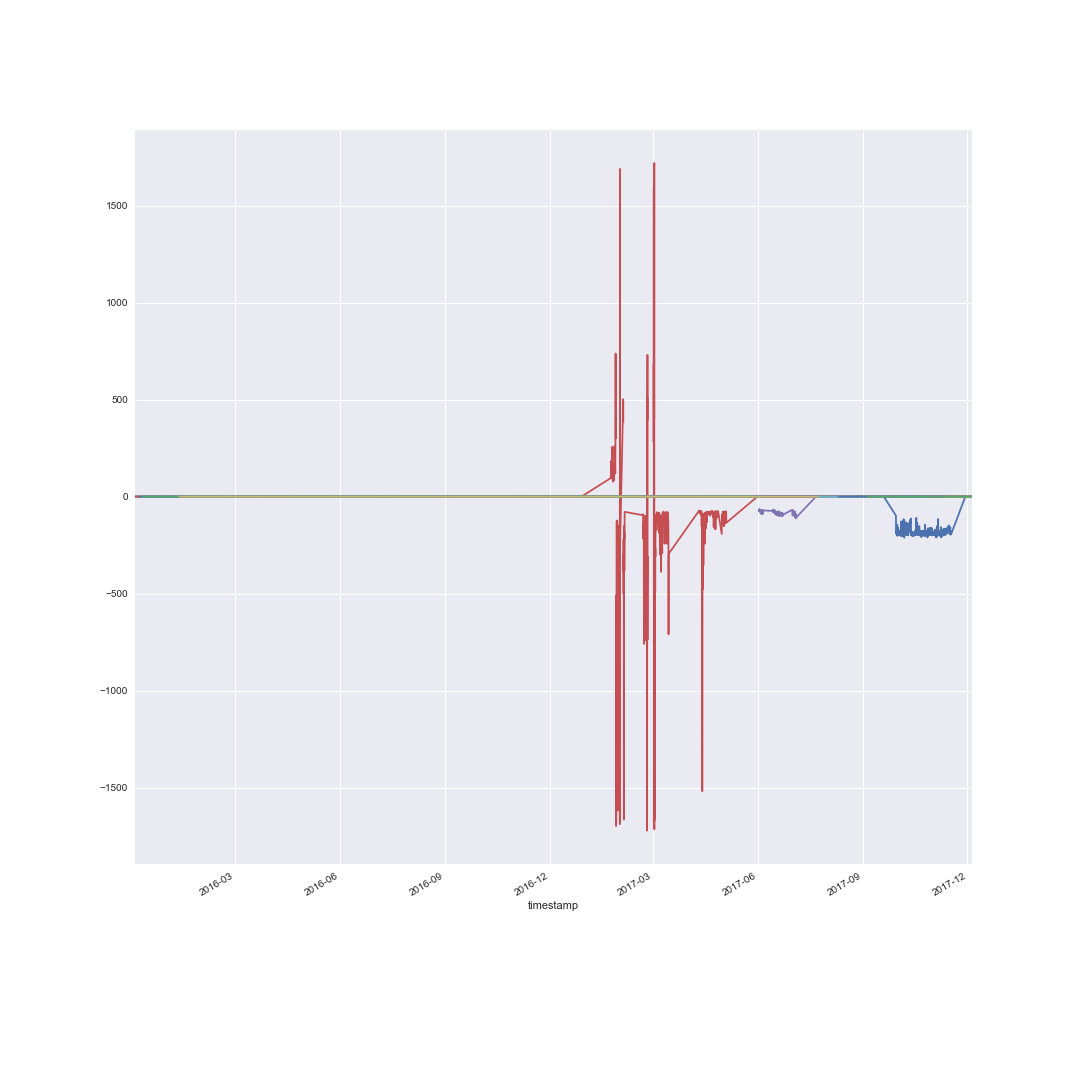

In [43]:
from IPython.core.display import Image, display
print('Here is an example of a feature plot:')
display(Image('./AnomalyDetectionMachineData/data/feature_plots/model1/perf_c_pr1.png'))

### Generate feature correlation maps and determine the highest correlating features
We can see that of the top 10 correlating pairs, most of them are temperatures. This is as expected as temperatures should rise simultaneously.

For model1: 


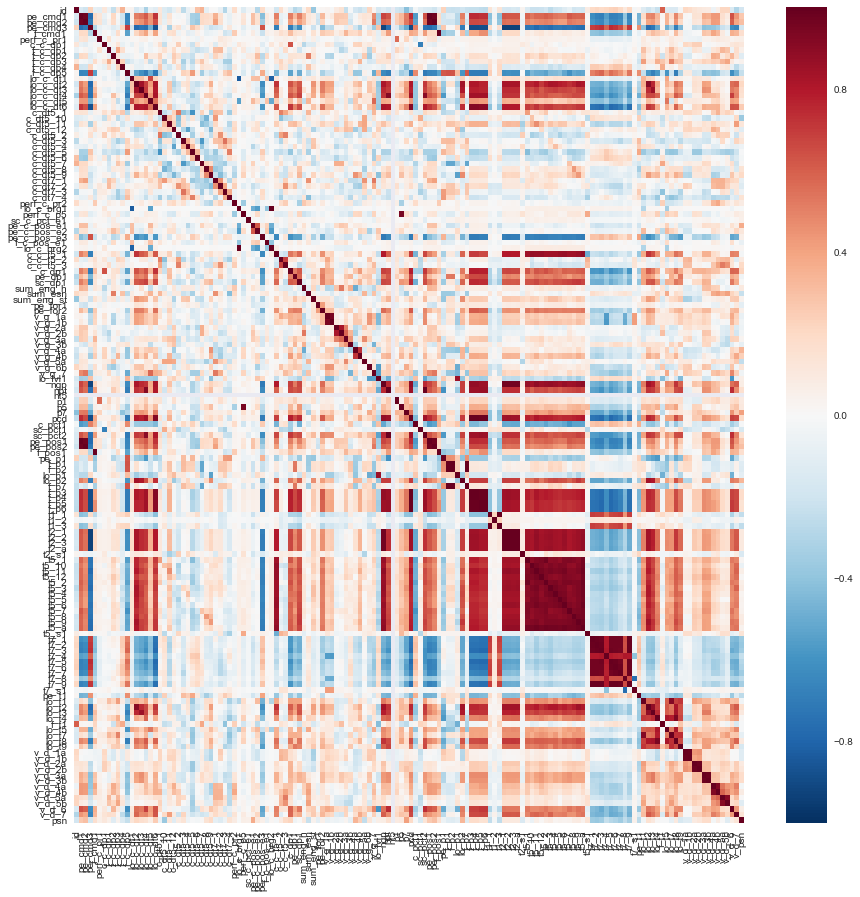

In [55]:
print('For model1: ')
model1_corr = model1.corr()
sns.heatmap(model1_corr)
plt.show()

In [57]:
# https://stackoverflow.com/a/41453817

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(model1[data_cols1],10))

f_p5     f_p6       0.999989
f_p3     f_p4       0.999986
f_p2     f_p7       0.999964
pe_cmd1  pe_pos1    0.999954
pe_cmd2  pe_pos2    0.999947
pcd      f_p4       0.999656
         f_p3       0.999645
f_p1     f_p7       0.999624
         f_p2       0.999606
t2_3     t2_a       0.999578
dtype: float64


For model2: 


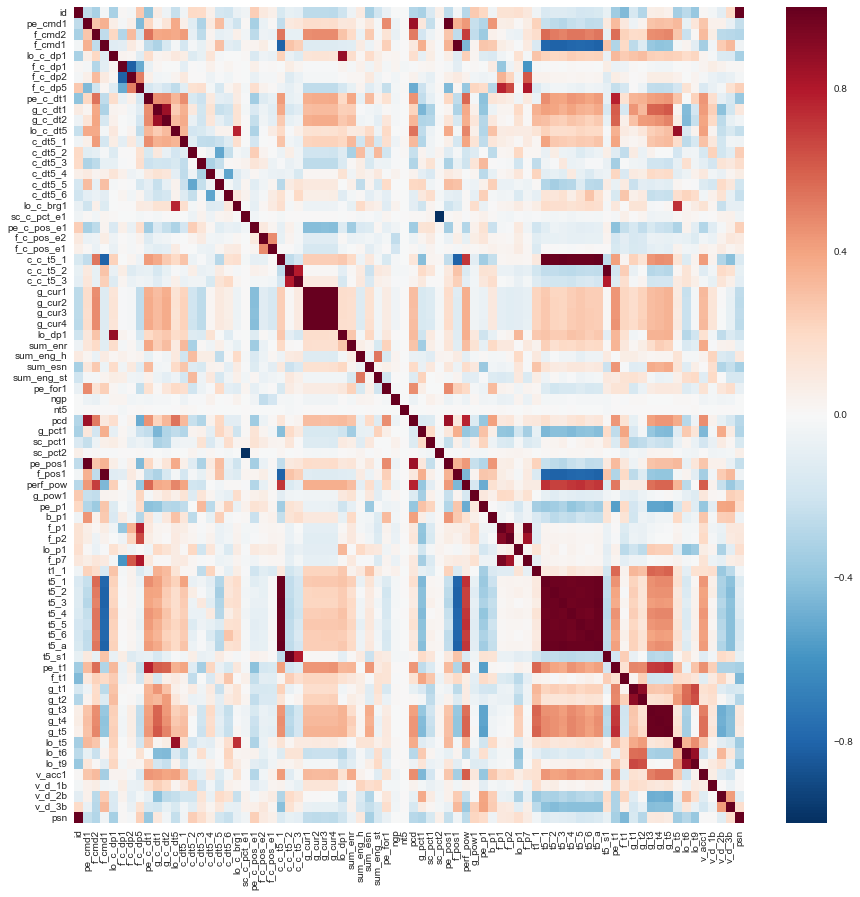

In [58]:
print('For model2: ')
model2_corr = model2.corr()
sns.heatmap(model2_corr)
plt.show()

In [58]:
print(get_top_abs_correlations(model2[data_cols2],10))

c_c_t5_2     t5_s1      1.000000
c_c_t5_1     t5_a       0.999981
pe_cmd1      pe_pos1    0.999959
f_cmd1       f_pos1     0.999919
g_cur2       g_cur3     0.999854
sc_c_pct_e1  sc_pct2    0.999838
g_cur1       g_cur2     0.999836
g_cur2       g_cur4     0.999835
g_cur1       g_cur3     0.999553
g_cur3       g_cur4     0.999551
dtype: float64


## 3. Initial PCA


In [60]:
def plot_component_explained_variance(data):
    pca = PCA()
    pca.fit(data)
    
    plt.plot(pca.explained_variance_[:10])
    plt.show()

def plot_3d_reduced(data, colors = None, pca=PCA(n_components=3)):
    reduced = pca.fit_transform(data)
    
    x = [r[0] for r in reduced]
    y = [r[1] for r in reduced]
    z = [r[2] for r in reduced]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z, c=colors)
    
    plt.show()
    return reduced

def plot_2d_reduced(data, colors = None, pca=PCA(n_components=2)):
    reduced = pca.fit_transform(data)
    
    x = [r[0] for r in reduced]
    y = [r[1] for r in reduced]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y, c=colors)
    
    plt.show()
    return reduced

Model1 with null dropped: 


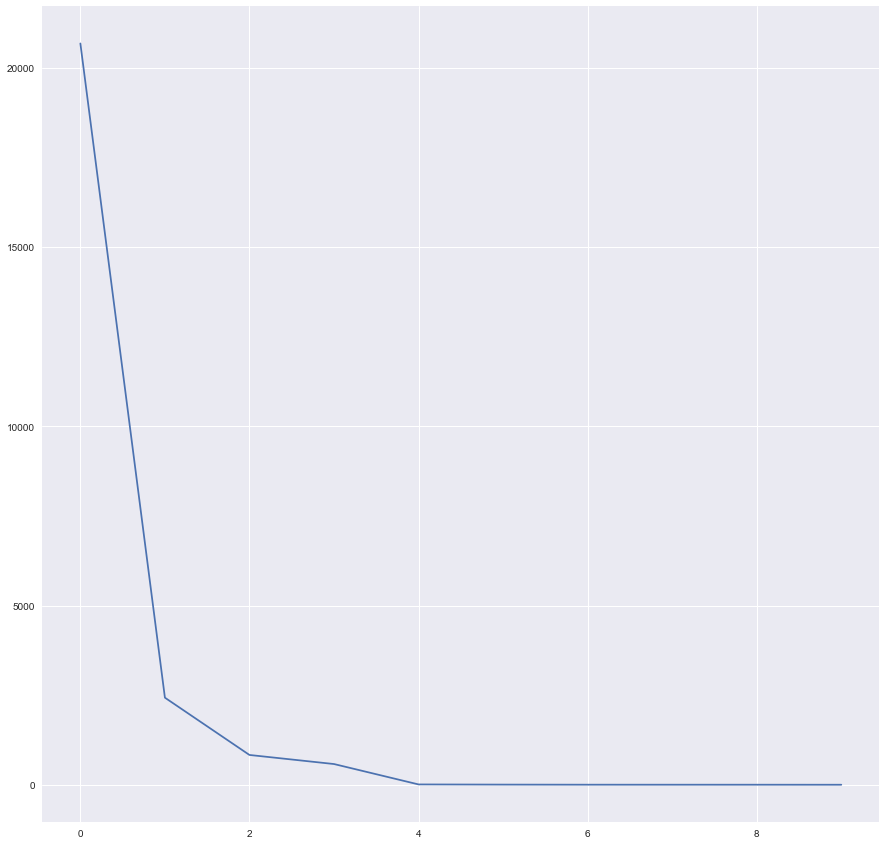

In [62]:
print('Model1 with null dropped: ')
plot_component_explained_variance(model1_dropna[data_cols1])
plot_3d_reduced(model1_dropna[data_cols1][:10000], pca=KernelPCA(n_components=3, kernel='sigmoid'))

Model2 with null dropped: 


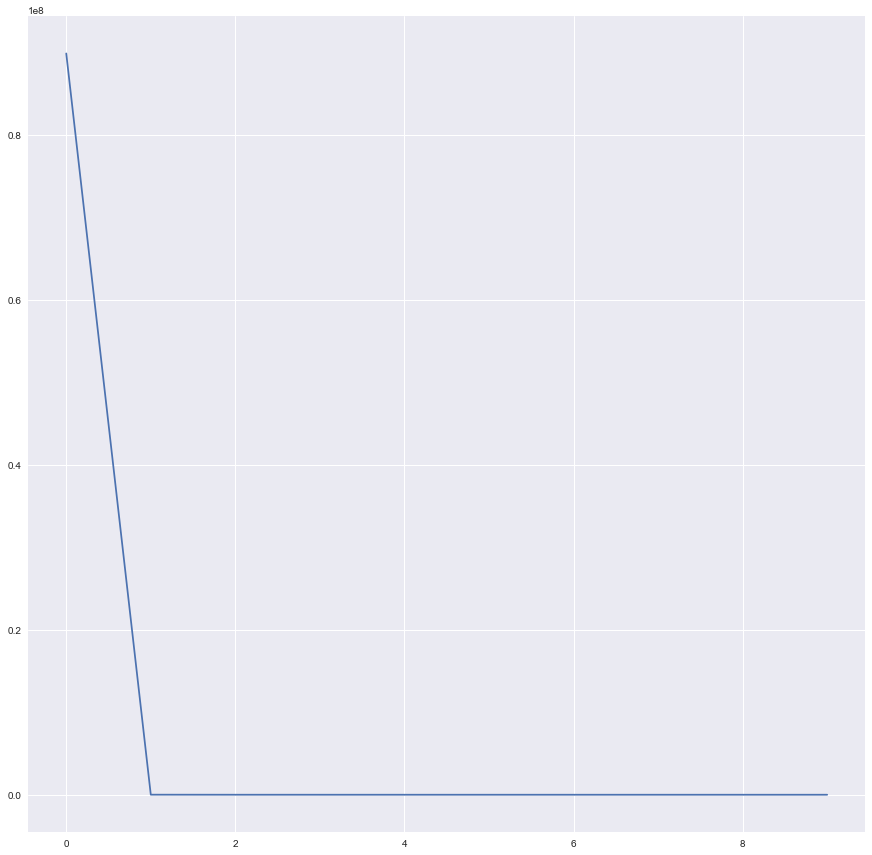

In [63]:
print('Model2 with null dropped: ')
plot_component_explained_variance(model2_dropna[data_cols2])
plot_3d_reduced(model2_dropna[data_cols2][:10000], pca=KernelPCA(n_components=3, kernel='sigmoid'))